In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


# from sklearn.decomposition import PCA
from scipy import stats
# from sklearn.cluster import KMeans
# from sklearn import metrics
# from scipy.spatial.distance import cdist
# from sklearn.metrics import davies_bouldin_score

import pickle
import copy
# from shapely import geometry
# from sklearn.metrics.pairwise import euclidean_distances
# import statsmodels.api as sm
from scipy.stats import linregress
# from sklearn.metrics import accuracy_score
import math
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# from scipy.stats import ks_2samp

In [2]:
import string
abcd = list(string.ascii_lowercase)

In [3]:
names_reanalyses = ['ERA5',
                   'JRA3Q',
                   'NCEP_NCAR']

In [4]:
wr=1

In [5]:
names_wrs = ["Polar High", "Pacific Trough", "Pacific Ridge", "Alaskan Ridge", "Atlantic Ridge" ,"No WR"]

In [6]:
colors_reanalyses = {'ERA5':'k','JRA3Q':'red','NCEP_NCAR':'blue'}

In [7]:
from scipy.stats import theilslopes
import statsmodels.api as sm

In [8]:
dic_labels = {}
for reanalysis in names_reanalyses:
    labels_temp = pd.read_csv(f'../ProcessZ500/labels/df_labels_nocorrfilt_{reanalysis}.csv', parse_dates=True, index_col=0, 
                              names=['WR','distances','corr'], skiprows=1)#[['WR']]
    labels_temp = labels_temp['1948':]
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    labels_temp.loc[labels_temp['corr']<=0.2,'WR']=np.unique(labels_temp['WR'])[-1]
    dic_labels[reanalysis] = labels_temp

In [9]:
dic_events = {}

for ir, reanalysis in enumerate(names_reanalyses):
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels[reanalysis])
    
    df_labels['season'] = df_labels.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_labels['season'] = df_labels['season'].map(season_map)
    
    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    # df_events = df_events[df_events['duration']>=4]
    dic_events[reanalysis] = df_events

/glade/derecho/scratch/jhayron/tmp/ipykernel_20349/2337241071.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_20349/2337241071.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_20349/2337241071.py:16: FutureWarning: A value

In [10]:
N=30

dic_stats_durations = {}
dic_dfs_durations = {}

for ir, reanalysis in enumerate(names_reanalyses):
    dic_stats_durations[reanalysis] = {}
    dic_dfs_durations[reanalysis] = {}
    start_year = dic_labels[reanalysis].index.year[0] + (N-1)
    end_year = dic_labels[reanalysis].index.year[-1]
    for wr in range(6):
        df_temp = copy.deepcopy(dic_events[reanalysis])
        df_temp = df_temp[(df_temp['season']=='Winter')|(df_temp['season']=='Spring')]
        df_temp = df_temp[df_temp['WR']==wr]
        
        dic_stats_temp = {}
        dic_stats_temp['mean'] = []
        dic_stats_temp['std'] = []
        dic_stats_temp['p90'] = []
        dic_stats_temp['p10'] = []
        dic_stats_temp['p95'] = []
        dic_stats_temp['p05'] = []
        dic_stats_temp['n_events'] = []
        dic_stats_temp['n_days'] = []
        
        for year in range(start_year, end_year+1):
            df_temp_temp = df_temp.loc[str(year-N+1):str(year)]['duration']
            dic_stats_temp['mean'].append(df_temp_temp.mean())
            dic_stats_temp['std'].append(df_temp_temp.std())
            dic_stats_temp['p90'].append(df_temp_temp.quantile(0.9))
            dic_stats_temp['p10'].append(df_temp_temp.quantile(0.1))
            dic_stats_temp['p95'].append(df_temp_temp.quantile(0.95))
            dic_stats_temp['p05'].append(df_temp_temp.quantile(0.05))

            dic_stats_temp['n_events'].append(len(df_temp_temp)/30)
            dic_stats_temp['n_days'].append(df_temp_temp.sum()/(30*365/2))
        df_stats_temp = pd.DataFrame(dic_stats_temp,index=np.arange(start_year,end_year+1))
        dic_stats_durations[reanalysis][f'wr{wr}'] = df_stats_temp
        dic_dfs_durations[reanalysis][f'wr{wr}'] = df_temp

In [11]:
wr=1
# Plot metrics
df_stats_temp = copy.deepcopy(dic_stats_durations['ERA5'][f'wr{wr}'])
df_events_temp = copy.deepcopy(dic_dfs_durations['ERA5'][f'wr{wr}'])
is_leap_year = df_events_temp.index.is_leap_year
total_days_in_year = np.where(is_leap_year, 366, 365)

# Convert DatetimeIndex to years in decimals
df_events_temp['year_decimal'] = (df_events_temp.index.year + (df_events_temp.index.dayofyear / total_days_in_year)).values

years = df_stats_temp.index
yearly_count = df_events_temp.groupby('year').sum()['duration']
yearly_count = yearly_count.reindex(index=np.arange(1948,2024))

In [12]:
yearly_freq = 100*yearly_count/(365/2)

In [13]:
yearly_freq = yearly_freq.fillna(0)

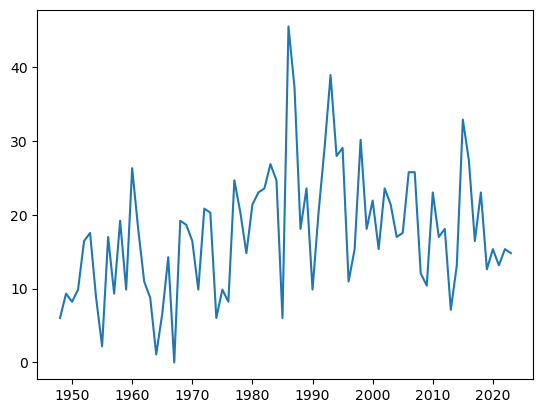

In [14]:
plt.plot(yearly_freq)

In [15]:
df_test = pd.read_csv('../ProcessZ500/labels/df_labels_nocorrfilt_ERA5.csv',
                      index_col=0,parse_dates=True)
df_test = df_test['1948-01-01':'2023-12-31']

df_test.loc[df_test['corr']<=0.2,'WR']=np.unique(df_test['WR'])[-1]#[df_test_season['WR']==wr]
df_test_season = df_test.loc[(df_test.index.month>=12)|(df_test.index.month<=5)]

# Z500 anoms

In [70]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/Z500Anoms_ERA5.nc').Z_anom.compute()
# region for clustering
lat0 = 20; lat1 = 80; lon0 = 180; lon1 = 330

anoms = anoms.where((anoms.lat>=lat0)&(anoms.lat<=lat1)&\
                   (anoms.lon>=lon0)&(anoms.lon<=lon1),drop=True)

temp_temp = anoms.sel(time=df_test_season[df_test_season['WR']==wr].index)
composite = temp_temp.mean('time')

In [25]:
bootstrapped_composites = []

for rs in range(1000):
    np.random.seed(rs)
    random_indices = np.random.choice(np.arange(len(df_test_season)),
                     size=len(df_test_season[df_test_season['WR']==wr]),
                    replace=True)
    temp_temp_rand = anoms.isel(time=random_indices)
    bootstrapped_composites.append(temp_temp_rand.mean('time'))

In [71]:
bootstrapped_composites = xr.concat(bootstrapped_composites, dim='bootstrap_iteration')
q05 = bootstrapped_composites.quantile(0.05,dim='bootstrap_iteration').drop_vars('quantile')
q95 = bootstrapped_composites.quantile(0.95,dim='bootstrap_iteration').drop_vars('quantile')

ds_composite = xr.Dataset({'composite':copy.deepcopy(composite),
     'q05':q05,
     'q95':q95})
ds_composite.to_netcdf('composites_data/z500_anoms.nc')

In [75]:
arr = ds_composite.composite.values
arr[(arr<=ds_composite.q95.values)&(arr>=ds_composite.q05.values)] = np.nan
ds_composite.composite.data = arr

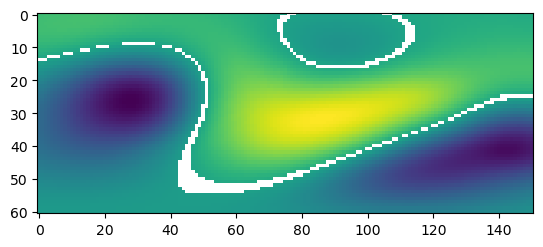

In [77]:
plt.imshow(ds_composite.composite)

# Precip anoms

In [78]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Precip/ERA5/PRECIP_ERA5_DailyAnoms_Std.nc')\
    .DailyPrecip.compute()
# region for clustering
lat0 = 20; lat1 = 80; lon0 = 180; lon1 = 330

anoms = anoms.where((anoms.lat>=lat0)&(anoms.lat<=lat1)&\
                   (anoms.lon>=lon0)&(anoms.lon<=lon1),drop=True)

temp_temp = anoms.sel(time=df_test_season[df_test_season['WR']==wr].index)
composite = temp_temp.mean('time')

In [79]:
bootstrapped_composites = []

for rs in range(1000):
    np.random.seed(rs)
    random_indices = np.random.choice(np.arange(len(df_test_season)),
                     size=len(df_test_season[df_test_season['WR']==wr]),
                    replace=True)
    temp_temp_rand = anoms.isel(time=random_indices)
    bootstrapped_composites.append(temp_temp_rand.mean('time'))

In [80]:
bootstrapped_composites = xr.concat(bootstrapped_composites, dim='bootstrap_iteration')
q05 = bootstrapped_composites.quantile(0.05,dim='bootstrap_iteration').drop_vars('quantile')
q95 = bootstrapped_composites.quantile(0.95,dim='bootstrap_iteration').drop_vars('quantile')

ds_composite = xr.Dataset({'composite':copy.deepcopy(composite),
     'q05':q05,
     'q95':q95})
ds_composite.to_netcdf('composites_data/precip_anoms.nc')

/glade/work/jhayron/conda-envs/weather_regimes/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [81]:
arr = ds_composite.composite.values
arr[(arr<=ds_composite.q95.values)&(arr>=ds_composite.q05.values)] = np.nan
ds_composite.composite.data = arr

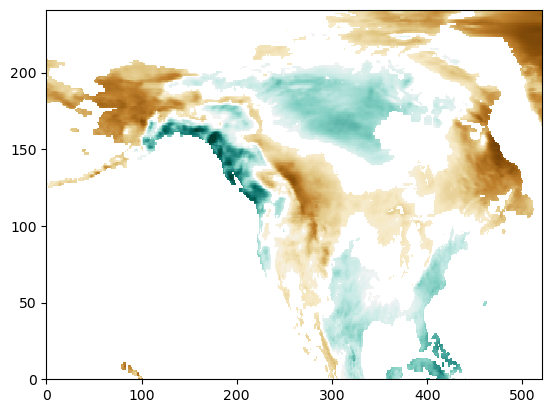

In [83]:
plt.pcolormesh(ds_composite.composite,vmin=-0.3,vmax=0.3,cmap='BrBG')

# Tmax

In [16]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TMax_ERA5_DailyAnoms_Std.nc')\
    .MaxTemp.compute()
# region for clustering
lat0 = 20; lat1 = 80; lon0 = 180; lon1 = 330

anoms = anoms.where((anoms.lat>=lat0)&(anoms.lat<=lat1)&\
                   (anoms.lon>=lon0)&(anoms.lon<=lon1),drop=True)

temp_temp = anoms.sel(time=df_test_season[df_test_season['WR']==wr].index)
composite = temp_temp.mean('time')

In [17]:
bootstrapped_composites = []

for rs in range(1000):
    np.random.seed(rs)
    random_indices = np.random.choice(np.arange(len(df_test_season)),
                     size=len(df_test_season[df_test_season['WR']==wr]),
                    replace=True)
    temp_temp_rand = anoms.isel(time=random_indices)
    bootstrapped_composites.append(temp_temp_rand.mean('time'))

In [18]:
bootstrapped_composites = xr.concat(bootstrapped_composites, dim='bootstrap_iteration')
q05 = bootstrapped_composites.quantile(0.05,dim='bootstrap_iteration').drop_vars('quantile')
q95 = bootstrapped_composites.quantile(0.95,dim='bootstrap_iteration').drop_vars('quantile')

ds_composite = xr.Dataset({'composite':copy.deepcopy(composite),
     'q05':q05,
     'q95':q95})
ds_composite.to_netcdf('composites_data/tmax_anoms.nc')

/glade/work/jhayron/conda-envs/weather_regimes/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [19]:
arr = ds_composite.composite.values
arr[(arr<=ds_composite.q95.values)&(arr>=ds_composite.q05.values)] = np.nan
ds_composite.composite.data = arr

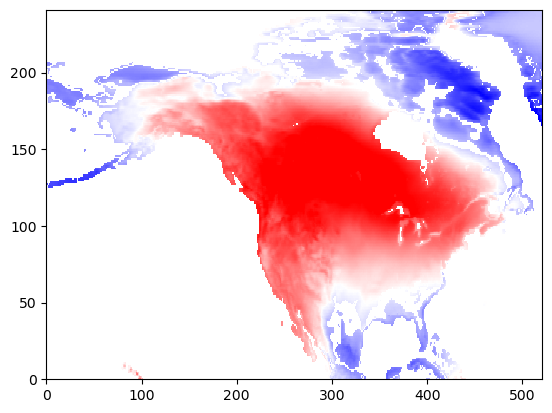

In [21]:
plt.pcolormesh(ds_composite.composite,vmin=-0.5,vmax=0.5,cmap='bwr')

# Tmin

In [22]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TMin_ERA5_DailyAnoms_Std.nc')\
    .MinTemp.compute()
# region for clustering
lat0 = 20; lat1 = 80; lon0 = 180; lon1 = 330

anoms = anoms.where((anoms.lat>=lat0)&(anoms.lat<=lat1)&\
                   (anoms.lon>=lon0)&(anoms.lon<=lon1),drop=True)

temp_temp = anoms.sel(time=df_test_season[df_test_season['WR']==wr].index)
composite = temp_temp.mean('time')

In [23]:
bootstrapped_composites = []

for rs in range(1000):
    np.random.seed(rs)
    random_indices = np.random.choice(np.arange(len(df_test_season)),
                     size=len(df_test_season[df_test_season['WR']==wr]),
                    replace=True)
    temp_temp_rand = anoms.isel(time=random_indices)
    bootstrapped_composites.append(temp_temp_rand.mean('time'))

In [24]:
bootstrapped_composites = xr.concat(bootstrapped_composites, dim='bootstrap_iteration')
q05 = bootstrapped_composites.quantile(0.05,dim='bootstrap_iteration').drop_vars('quantile')
q95 = bootstrapped_composites.quantile(0.95,dim='bootstrap_iteration').drop_vars('quantile')

ds_composite = xr.Dataset({'composite':copy.deepcopy(composite),
     'q05':q05,
     'q95':q95})
ds_composite.to_netcdf('composites_data/tmin_anoms.nc')

/glade/work/jhayron/conda-envs/weather_regimes/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [25]:
arr = ds_composite.composite.values
arr[(arr<=ds_composite.q95.values)&(arr>=ds_composite.q05.values)] = np.nan
ds_composite.composite.data = arr

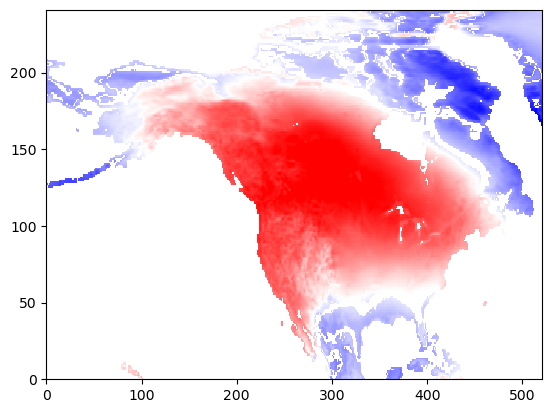

In [26]:
plt.pcolormesh(ds_composite.composite,vmin=-0.5,vmax=0.5,cmap='bwr')

# warm spells

In [18]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/warm_spells.nc')\
    .start_durations.compute()
# region for clustering
lat0 = 20; lat1 = 80; lon0 = 180; lon1 = 330

anoms = anoms.where((anoms.lat>=lat0)&(anoms.lat<=lat1)&\
                   (anoms.lon>=lon0)&(anoms.lon<=lon1),drop=True)
unique_years = np.unique(pd.to_datetime(anoms.time).year)

temp_temp = anoms.sel(time=df_test_season[df_test_season['WR']==wr].index)
composite = temp_temp.sum('time')/len(unique_years)

In [19]:
composite_full_season = anoms.sel(time=df_test_season.index).sum('time')/len(unique_years)
composite_full_season = xr.Dataset({'composite':copy.deepcopy(composite_full_season)})
composite_full_season.to_netcdf('composites_data/warm_spells_count_season.nc')

In [45]:
bootstrapped_composites = []

for rs in range(1000):
    np.random.seed(rs)
    random_indices = np.random.choice(np.arange(len(df_test_season)),
                     size=len(df_test_season[df_test_season['WR']==wr]),
                    replace=True)
    temp_temp_rand = anoms.isel(time=random_indices)
    bootstrapped_composites.append(temp_temp_rand.sum('time')/len(unique_years))


In [47]:
bootstrapped_composites = xr.concat(bootstrapped_composites, dim='bootstrap_iteration')
q05 = bootstrapped_composites.quantile(0.05,dim='bootstrap_iteration').drop_vars('quantile')
q95 = bootstrapped_composites.quantile(0.95,dim='bootstrap_iteration').drop_vars('quantile')
q90 = bootstrapped_composites.quantile(0.9,dim='bootstrap_iteration').drop_vars('quantile')

ds_composite = xr.Dataset({'composite':copy.deepcopy(composite),
     'q05':q05,
     'q95':q95,
     'q90':q90})
ds_composite.to_netcdf('composites_data/warm_spells_count.nc')

In [48]:
arr = ds_composite.composite.values
arr[(arr<=ds_composite.q90.values)] = np.nan
ds_composite.composite.data = arr

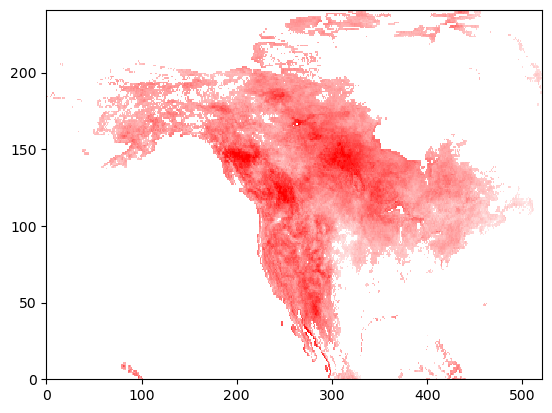

In [49]:
plt.pcolormesh(ds_composite.composite,vmin=-0.5,vmax=0.5,cmap='bwr')

# TX>90p

In [16]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TMaxp90_ERA5.nc')\
    .MaxTemp.compute()
# region for clustering
lat0 = 20; lat1 = 80; lon0 = 180; lon1 = 330

anoms = anoms.where((anoms.lat>=lat0)&(anoms.lat<=lat1)&\
                   (anoms.lon>=lon0)&(anoms.lon<=lon1),drop=True)
unique_years = np.unique(pd.to_datetime(anoms.time).year)

temp_temp = anoms.sel(time=df_test_season[df_test_season['WR']==wr].index)
composite = temp_temp.sum('time')/len(unique_years)

In [17]:
composite_full_season = anoms.sel(time=df_test_season.index).sum('time')/len(unique_years)
composite_full_season = xr.Dataset({'composite':copy.deepcopy(composite_full_season)})
composite_full_season.to_netcdf('composites_data/tx90_count_season.nc')

In [ ]:
bootstrapped_composites = []

for rs in range(1000):
    np.random.seed(rs)
    random_indices = np.random.choice(np.arange(len(df_test_season)),
                     size=len(df_test_season[df_test_season['WR']==wr]),
                    replace=True)
    temp_temp_rand = anoms.isel(time=random_indices)
    bootstrapped_composites.append(temp_temp_rand.sum('time')/len(unique_years))


In [ ]:
bootstrapped_composites = xr.concat(bootstrapped_composites, dim='bootstrap_iteration')
q05 = bootstrapped_composites.quantile(0.05,dim='bootstrap_iteration').drop_vars('quantile')
q95 = bootstrapped_composites.quantile(0.95,dim='bootstrap_iteration').drop_vars('quantile')
q90 = bootstrapped_composites.quantile(0.9,dim='bootstrap_iteration').drop_vars('quantile')

ds_composite = xr.Dataset({'composite':copy.deepcopy(composite),
     'q05':q05,
     'q95':q95,
     'q90':q90})
ds_composite.to_netcdf('composites_data/tx90_count.nc')

In [ ]:
arr = ds_composite.composite.values
arr[(arr<=ds_composite.q90.values)] = np.nan
ds_composite.composite.data = arr

In [ ]:
plt.pcolormesh(ds_composite.composite,vmin=-0.5,vmax=0.5,cmap='bwr')

# TN>90p

In [ ]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TMinp90_ERA5.nc')\
    .MinTemp.compute()
# region for clustering
lat0 = 20; lat1 = 80; lon0 = 180; lon1 = 330

anoms = anoms.where((anoms.lat>=lat0)&(anoms.lat<=lat1)&\
                   (anoms.lon>=lon0)&(anoms.lon<=lon1),drop=True)
unique_years = np.unique(pd.to_datetime(anoms.time).year)

temp_temp = anoms.sel(time=df_test_season[df_test_season['WR']==wr].index)
composite = temp_temp.sum('time')/len(unique_years)

In [ ]:
bootstrapped_composites = []

for rs in range(1000):
    np.random.seed(rs)
    random_indices = np.random.choice(np.arange(len(df_test_season)),
                     size=len(df_test_season[df_test_season['WR']==wr]),
                    replace=True)
    temp_temp_rand = anoms.isel(time=random_indices)
    bootstrapped_composites.append(temp_temp_rand.sum('time')/len(unique_years))


In [ ]:
bootstrapped_composites = xr.concat(bootstrapped_composites, dim='bootstrap_iteration')
q05 = bootstrapped_composites.quantile(0.05,dim='bootstrap_iteration').drop_vars('quantile')
q95 = bootstrapped_composites.quantile(0.95,dim='bootstrap_iteration').drop_vars('quantile')
q90 = bootstrapped_composites.quantile(0.9,dim='bootstrap_iteration').drop_vars('quantile')

ds_composite = xr.Dataset({'composite':copy.deepcopy(composite),
     'q05':q05,
     'q95':q95,
     'q90':q90})
ds_composite.to_netcdf('composites_data/tn90_count.nc')

In [ ]:
arr = ds_composite.composite.values
arr[(arr<=ds_composite.q90.values)] = np.nan
ds_composite.composite.data = arr

In [ ]:
plt.pcolormesh(ds_composite.composite,vmin=-0.5,vmax=0.5,cmap='bwr')

# Summer days

In [83]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TX25_ERA5.nc')\
    .MaxTemp.compute()
# region for clustering
lat0 = 20; lat1 = 80; lon0 = 180; lon1 = 330

anoms = anoms.where((anoms.lat>=lat0)&(anoms.lat<=lat1)&\
                   (anoms.lon>=lon0)&(anoms.lon<=lon1),drop=True)
unique_years = np.unique(pd.to_datetime(anoms.time).year)

temp_temp = anoms.sel(time=df_test_season[df_test_season['WR']==wr].index)
composite = temp_temp.sum('time')/len(unique_years)

In [84]:
bootstrapped_composites = []

for rs in range(10):
    np.random.seed(rs)
    random_indices = np.random.choice(np.arange(len(df_test_season)),
                     size=len(df_test_season[df_test_season['WR']==wr]),
                    replace=True)
    temp_temp_rand = anoms.isel(time=random_indices)
    bootstrapped_composites.append(temp_temp_rand.sum('time')/len(unique_years))


In [85]:
bootstrapped_composites = xr.concat(bootstrapped_composites, dim='bootstrap_iteration')
q05 = bootstrapped_composites.quantile(0.05,dim='bootstrap_iteration').drop_vars('quantile')
q95 = bootstrapped_composites.quantile(0.95,dim='bootstrap_iteration').drop_vars('quantile')
q90 = bootstrapped_composites.quantile(0.9,dim='bootstrap_iteration').drop_vars('quantile')

ds_composite = xr.Dataset({'composite':copy.deepcopy(composite),
     'q05':q05,
     'q95':q95,
     'q90':q90})
ds_composite.to_netcdf('composites_data/tx25_count.nc')

In [86]:
arr = ds_composite.composite.values
# arr[(arr<=ds_composite.q90.values)] = np.nan
ds_composite.composite.data = arr

In [87]:
composite_full_season = anoms.sel(time=df_test_season.index).sum('time')/len(unique_years)

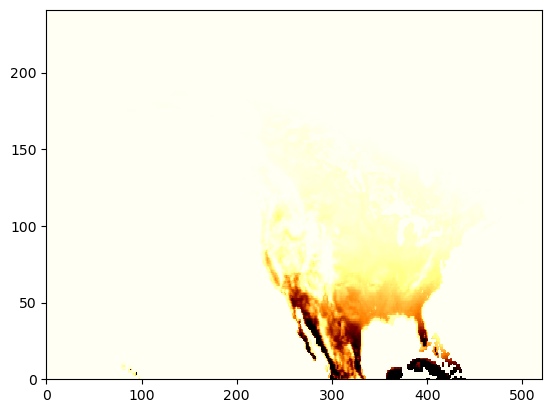

In [47]:
plt.pcolormesh(ds_composite.composite,vmin=-0.5,vmax=20,cmap='afmhot_r')

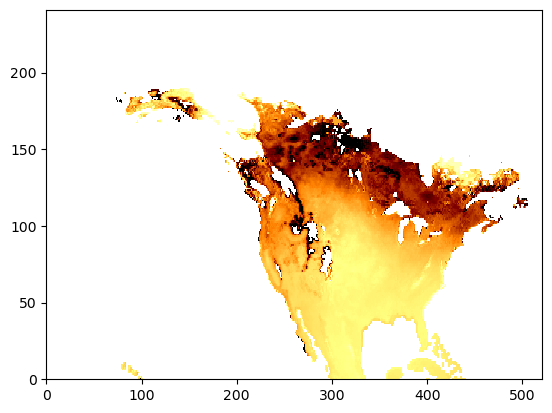

In [93]:
plt.pcolormesh(ds_composite.composite/composite_full_season,vmin=0,vmax=0.6,cmap='afmhot_r')

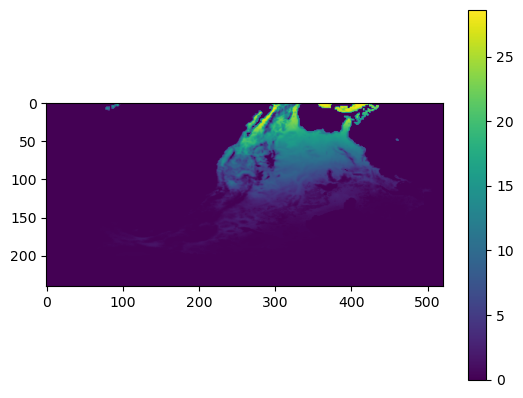

In [51]:
plt.imshow(ds_composite.q90.values)
plt.colorbar()

# Tropical nights

In [131]:
tn20 = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TN20_ERA5.nc')
yearly_mean = tn20['MinTemp'].sel(time=df_test_season.index).groupby('time.year').sum(dim='time')
# Example usage (assuming your DataArray is 'precip_yearly' and time series is 'duration_series'):
correlation_dataset = calculate_pixel_correlation_vectorized(yearly_mean, yearly_freq)
arr_temp = correlation_dataset.correlation.values
arr_temp[correlation_dataset.p_value.values>=0.05] = np.nan
correlation_dataset.correlation.data = arr_temp

/glade/derecho/scratch/jhayron/tmp/ipykernel_46155/1160873315.py:31: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)


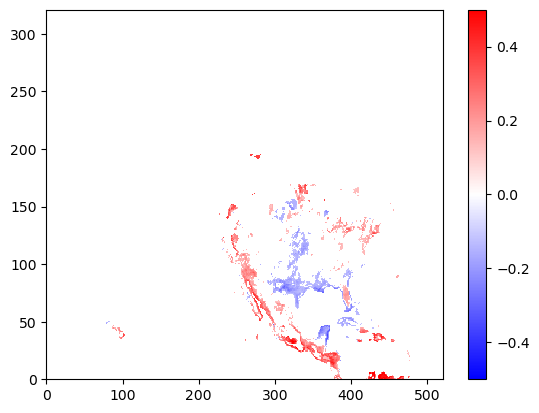

In [132]:
plt.pcolormesh(correlation_dataset.correlation,vmin=-0.5,vmax=0.5,cmap='bwr')
plt.colorbar()

# Fires

In [16]:
fires_db = pd.read_csv('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Fires/fire_archive_M-C61_584056.csv',
                 index_col=5,parse_dates=True)
fires_db = fires_db[fires_db.confidence>=80]
fires_db = fires_db['2004':'2023']

def count_events(latitudes, longitudes, lat_range=(10, 90), lon_range=(-180, -30), box_size=1.0):
    """
    Creates a 2D array counting events within a variable size grid.

    Args:
        latitudes (pd.Series): Series of latitudes.
        longitudes (pd.Series): Series of longitudes.
        lat_range (tuple): Latitude range (min, max).
        lon_range (tuple): Longitude range (min, max).
        box_size (float): Size of the grid box (e.g., 1.0 for 1x1 degree, 0.5 for 0.5x0.5 degree).

    Returns:
        numpy.ndarray: 2D array with event counts.
        numpy.ndarray: array of latitude grid values
        numpy.ndarray: array of longitude grid values
    """

    lat_min, lat_max = lat_range
    lon_min, lon_max = lon_range

    lat_bins = np.arange(lat_min - box_size / 2, lat_max + box_size / 2 + box_size, box_size)
    lon_bins = np.arange(lon_min - box_size / 2, lon_max + box_size / 2 + box_size, box_size)

    lat_indices = np.digitize(latitudes, lat_bins) - 1
    lon_indices = np.digitize(longitudes, lon_bins) - 1

    # Ensure indices are within bounds
    lat_indices = np.clip(lat_indices, 0, len(lat_bins) - 2)
    lon_indices = np.clip(lon_indices, 0, len(lon_bins) - 2)

    counts = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1), dtype=int)

    for lat_idx, lon_idx in zip(lat_indices, lon_indices):
        counts[lat_idx, lon_idx] += 1

    return counts, lat_bins[:-1] + box_size / 2, lon_bins[:-1] + box_size / 2

# Example Usage (Assuming fires_db is your DataFrame):
# counts_yearly, lat_grid, lon_grid, years_array = count_events_yearly(
#     fires_db.latitude, fires_db.longitude, fires_db.year, box_size=1.0
# )

# You can now use 'counts_yearly', 'lat_grid', 'lon_grid', and 'years_array' as needed.
# print(counts_yearly.shape)
# print(lat_grid.shape)
# print(lon_grid.shape)
# print(years_array.shape)

In [17]:
1994-1977

17

In [18]:
wrtemp=1
df_temp = df_test_season[df_test_season['WR']==wrtemp]
fires_temp = fires_db.loc[fires_db.index.intersection(df_temp.index)]
counts, lat_grid, lon_grid = count_events(
                            fires_temp.latitude, fires_temp.longitude,
                            lat_range=(20,80),
                            lon_range=(-180,-50),
                            box_size=2.5)
composite_fires = counts/20

In [19]:
composite_fires = xr.DataArray(
        composite_fires,
        coords={'lat': lat_grid, 'lon': lon_grid},
        dims=['lat', 'lon'],
        name='fire_composite'
    )


In [20]:
fires_temp = fires_db.loc[fires_db.index.intersection(df_test_season.index)]
counts, lat_grid, lon_grid = count_events(
                            fires_temp.latitude, fires_temp.longitude,
                            lat_range=(20,80),
                            lon_range=(-180,-50),
                            box_size=2.5)
composite_fires_seasonal = counts/20

composite_fires_seasonal = xr.DataArray(
        composite_fires_seasonal,
        coords={'lat': lat_grid, 'lon': lon_grid},
        dims=['lat', 'lon'],
        name='fire_composite'
    )



composite_fires_seasonal.to_netcdf('composites_data/fires_count_seasonal.nc')

In [21]:
bootstrapped_composites = []

for rs in range(1000):
    np.random.seed(rs)
    random_indices = np.random.choice(np.arange(len(df_test_season)),
                     size=len(df_test_season[df_test_season['WR']==wrtemp]),
                    replace=True)
    dates_random = df_test_season.iloc[random_indices].index
    
    fires_temp = fires_db.loc[fires_db.index.intersection(dates_random)]
    counts, lat_grid, lon_grid = count_events(
                                fires_temp.latitude, fires_temp.longitude,
                                lat_range=(20,80),
                                lon_range=(-180,-50),
                                box_size=2.5)
    composite_fires_random = counts/20
    composite_fires_random = xr.DataArray(
        composite_fires_random,
        coords={'lat': lat_grid, 'lon': lon_grid},
        dims=['lat', 'lon'],
        name='fire_composite'
    )
    bootstrapped_composites.append(composite_fires_random)

In [22]:
bootstrapped_composites = xr.concat(bootstrapped_composites, dim='bootstrap_iteration')
q05 = bootstrapped_composites.quantile(0.05,dim='bootstrap_iteration').drop_vars('quantile')
q95 = bootstrapped_composites.quantile(0.95,dim='bootstrap_iteration').drop_vars('quantile')
q90 = bootstrapped_composites.quantile(0.9,dim='bootstrap_iteration').drop_vars('quantile')

ds_composite = xr.Dataset({'composite':copy.deepcopy(composite_fires),
     'q05':q05,
     'q95':q95,
     'q90':q90})
ds_composite.to_netcdf('composites_data/fires_count.nc')

In [23]:
arr = ds_composite.composite.values
arr[(arr<=ds_composite.q90.values)] = np.nan
ds_composite.composite.data = arr

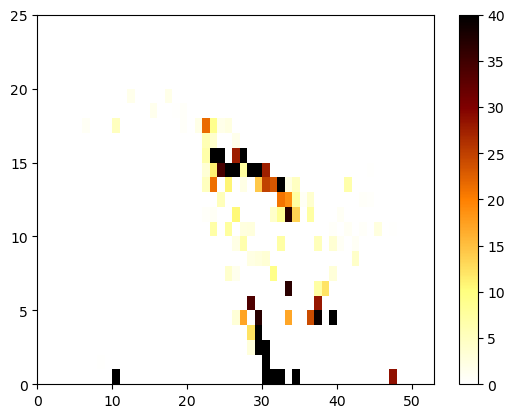

In [25]:
plt.pcolormesh(ds_composite.composite,cmap='afmhot_r',vmin=0,vmax=40)
plt.colorbar()

# number of wet days

In [108]:
wet_days = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Precip/ERA5/wet_days.nc')

yearly_mean = wet_days['DailyPrecip'].sel(time=df_test_season.index).groupby('time.year').sum(dim='time')
# Example usage (assuming your DataArray is 'precip_yearly' and time series is 'duration_series'):
correlation_dataset = calculate_pixel_correlation_vectorized(yearly_mean, yearly_freq)
arr_temp = correlation_dataset.correlation.values
arr_temp[correlation_dataset.p_value.values>=0.05] = np.nan
correlation_dataset.correlation.data = arr_temp

/glade/derecho/scratch/jhayron/tmp/ipykernel_46155/1160873315.py:31: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)


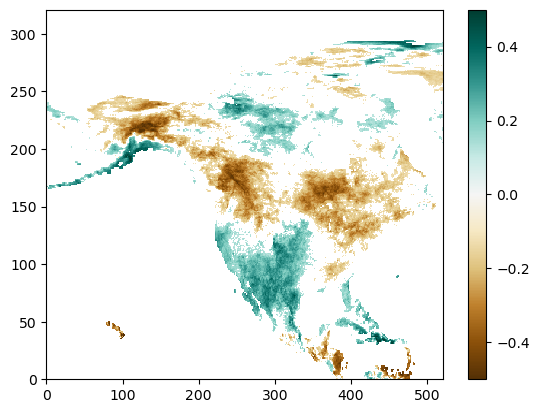

In [110]:
plt.pcolormesh(correlation_dataset.correlation,vmin=-0.5,vmax=0.5,cmap='BrBG')
plt.colorbar()

# number of dry days

In [ ]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Precip/ERA5/dry_days.nc')\
    .DailyPrecip.compute()
# region for clustering
lat0 = 20; lat1 = 80; lon0 = 180; lon1 = 330

anoms = anoms.where((anoms.lat>=lat0)&(anoms.lat<=lat1)&\
                   (anoms.lon>=lon0)&(anoms.lon<=lon1),drop=True)
unique_years = np.unique(pd.to_datetime(anoms.time).year)

temp_temp = anoms.sel(time=df_test_season[df_test_season['WR']==wr].index)
composite = temp_temp.sum('time')/len(unique_years)

In [ ]:
bootstrapped_composites = []

for rs in range(1000):
    np.random.seed(rs)
    random_indices = np.random.choice(np.arange(len(df_test_season)),
                     size=len(df_test_season[df_test_season['WR']==wr]),
                    replace=True)
    temp_temp_rand = anoms.isel(time=random_indices)
    bootstrapped_composites.append(temp_temp_rand.sum('time')/len(unique_years))


In [ ]:
bootstrapped_composites = xr.concat(bootstrapped_composites, dim='bootstrap_iteration')
q05 = bootstrapped_composites.quantile(0.05,dim='bootstrap_iteration').drop_vars('quantile')
q95 = bootstrapped_composites.quantile(0.95,dim='bootstrap_iteration').drop_vars('quantile')
q90 = bootstrapped_composites.quantile(0.9,dim='bootstrap_iteration').drop_vars('quantile')

ds_composite = xr.Dataset({'composite':copy.deepcopy(composite),
     'q05':q05,
     'q95':q95,
     'q90':q90})
ds_composite.to_netcdf('composites_data/drydays_count.nc')

In [ ]:
arr = ds_composite.composite.values
arr[(arr<=ds_composite.q90.values)] = np.nan
ds_composite.composite.data = arr

In [ ]:
plt.pcolormesh(ds_composite.composite,vmin=-0.5,vmax=0.5,cmap='bwr')

# Average duration of wet spells

In [115]:
dur_wet_spells = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Precip/ERA5/dur_wet_spells.nc')

yearly_mean = dur_wet_spells['__xarray_dataarray_variable__'].sel(time=df_test_season.index).groupby('time.year').mean(dim='time')
# Example usage (assuming your DataArray is 'precip_yearly' and time series is 'duration_series'):
correlation_dataset = calculate_pixel_correlation_vectorized(yearly_mean, yearly_freq)
arr_temp = correlation_dataset.correlation.values
arr_temp[correlation_dataset.p_value.values>=0.05] = np.nan
correlation_dataset.correlation.data = arr_temp

/glade/derecho/scratch/jhayron/tmp/ipykernel_46155/1160873315.py:28: RuntimeWarning: Mean of empty slice
  covariance = np.nanmean(((data_array - data_mean).values * (time_series_expanded - time_mean)),axis=0)#.mean(axis=0)


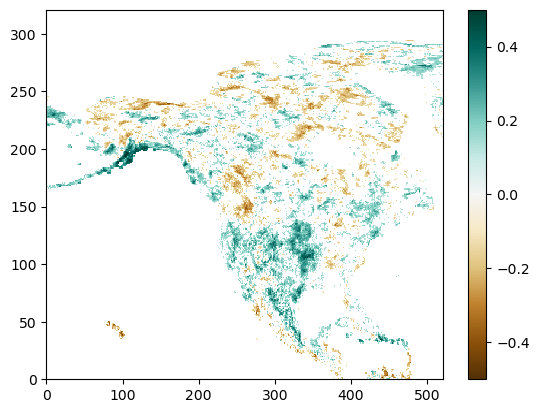

In [117]:
plt.pcolormesh(correlation_dataset.correlation,vmin=-0.5,vmax=0.5,cmap='BrBG')
plt.colorbar()

# Average duration of dry spells

In [16]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Precip/ERA5/dur_dry_spells.nc')\
    .__xarray_dataarray_variable__.compute()
# region for clustering
lat0 = 20; lat1 = 80; lon0 = 180; lon1 = 330

anoms = anoms.where((anoms.lat>=lat0)&(anoms.lat<=lat1)&\
                   (anoms.lon>=lon0)&(anoms.lon<=lon1),drop=True)
unique_years = np.unique(pd.to_datetime(anoms.time).year)

temp_temp = anoms.sel(time=df_test_season[df_test_season['WR']==wr].index)
composite = temp_temp.mean('time')

In [27]:
temp_temp = anoms.sel(time=df_test_season.index)
seasonal_mean = temp_temp.mean('time')
seasonal_std = temp_temp.std('time')

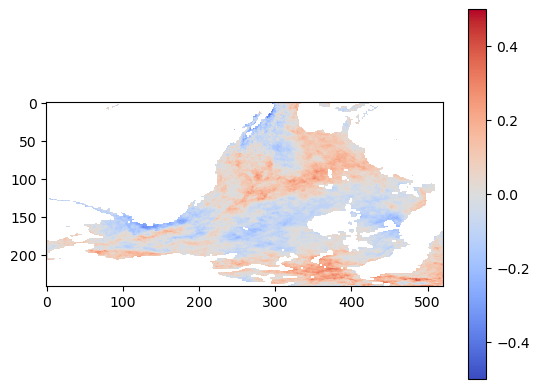

In [30]:
plt.imshow((composite-seasonal_mean)/seasonal_std,vmin=-0.5,vmax=0.5,cmap='coolwarm')
plt.colorbar()

In [35]:
ds_composite_full = xr.Dataset({'composite':copy.deepcopy(composite),
     'mean':seasonal_mean,
     'std':seasonal_std})
ds_composite_full.to_netcdf('composites_data/durdryspells_mean_full.nc')

In [ ]:
bootstrapped_composites = []

for rs in range(1000):
    np.random.seed(rs)
    random_indices = np.random.choice(np.arange(len(df_test_season)),
                     size=len(df_test_season[df_test_season['WR']==wr]),
                    replace=True)
    temp_temp_rand = anoms.isel(time=random_indices)
    bootstrapped_composites.append(temp_temp_rand.mean('time'))


In [ ]:
bootstrapped_composites = xr.concat(bootstrapped_composites, dim='bootstrap_iteration')
q05 = bootstrapped_composites.quantile(0.05,dim='bootstrap_iteration').drop_vars('quantile')
q95 = bootstrapped_composites.quantile(0.95,dim='bootstrap_iteration').drop_vars('quantile')
q90 = bootstrapped_composites.quantile(0.9,dim='bootstrap_iteration').drop_vars('quantile')

ds_composite = xr.Dataset({'composite':copy.deepcopy(composite),
     'q05':q05,
     'q95':q95,
     'q90':q90})
ds_composite.to_netcdf('composites_data/durdryspells_mean.nc')

In [ ]:
arr = ds_composite.composite.values
arr[(arr<=ds_composite.q90.values)] = np.nan
ds_composite.composite.data = arr

In [ ]:
plt.pcolormesh(ds_composite.composite,vmin=-0.5,vmax=0.5,cmap='bwr')